# Clustering tweets about sports using self-organizing maps

### Authors:  Elsa Scola Martín and Julen Miner Goñi

### Objectives:

-  extract the most recent tweets and cluster them using self-organized maps

### What is done in the Notebook: 

-  collect the tweets
-  extract the features
-  clustering and visualization using SOM
-  analyze and contrast the results

## Importing the libraries

In [2]:
# General:
import tweepy           # To consume Twitter's API
import pandas as pd     # To handle data
import numpy as np      # For number computing

# For plotting and visualization:
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
import somoclu
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

# For feature extraction:
import fasttext
from pattern.en import sentiment

## Creating a Twitter App 

In order to extract tweets for a posterior analysis, we need to access to our Twitter account and create an app. The website to do this is https://apps.twitter.com/. 
From this app that we are creating we will save the following information in a script called credentials.py:
- Consumer Key (API Key)
- Consumer Secret (API Secret)
- Access Token
- Access Token Secret

The reason of creating this extra file is that we want to export only the value of this variables, while being unseen in our notebook. We are now able to consume Twitter's API. In order to do this, we will create a function to allow the keys authentication.

In [2]:
# We import our access keys:
from credentials import *    # This will allow us to use the keys as variables

# API's setup:
def twitter_setup():
    """
    Utility function to setup the Twitter's API
    with our access keys provided.
    """
    # Authentication and access using keys:
    auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
    auth.set_access_token(ACCESS_TOKEN, ACCESS_SECRET)

    # Return API with authentication:
    api = tweepy.API(auth)
    return api

# We create an extractor object:
extractor = twitter_setup()

## Collecting tweets from UK

We want to ensure that at least the majority of the tweets we collect are written in english, therefore, once we have the API object instantiated we can use Tweepy’s geo_search method to query the Geo Search API. One English-speaker country is UK.

In [47]:
#Getting Geo ID for UK
places = extractor.geo_search(query="UK", granularity="country")

#Copy UK id
place_id = places[0].id
print('UK id is: ',place_id)

UK id is:  084d0d0155787e9d


Note that the search phrases are not case sensitive. We can search for all of these terms at once by separating them with OR in our query. We also included a filter that requires the tweet originate within the United States by adding place:084d0d0155787e9d at the beginning of the query, where 084d0d0155787e9d is the place_id we found with the Geo Search API.

In [48]:
#This is what we are searching for
#We can restrict the location of tweets using place:id 
#We can search for multiple phrases using OR
searchQuery = 'place:' + place_id + ' #ball OR "ball"'

Now we know which place_id to use as a filter in the Search API. Next, we’ll use the Search API to collect historical tweets. 

The search API only collects a random sample of tweets
There is no way to get more than the last week of tweets without purchasing them from a third-party provider
from the Search API documentation, note that we can use either user-authentication or application-only authentication to access the Search API. User-authentication allows for 180 queries per access token every 15 minutes, and application-only authentication allows for 450 queries every 15 minutes. Since we only have one access token to work with, we’ll want to switch to application-only authentication for the higher rate limit.

In [49]:
#You can check how many queries you have left using rate_limit_status() method
extractor.rate_limit_status()['resources']['search']

{'/search/tweets': {'limit': 180, 'remaining': 75, 'reset': 1543769389}}

We also need to define the maximum number of tweets that we want to collect, and the maximum number of tweets that we want to receive from each query that we send:

In [57]:
#Maximum number of tweets we want to collect 
maxTweets = 15000

#The twitter Search API allows up to 100 tweets per query
tweetsPerQry = 100

## Tweet extraction 

We first create a function that given a tweet returns True if it is a Retweet, we do this so there are no duplicated tweets on the dataset.

In [58]:
def isRT(tweet):
    return tweet.text.startswith("RT ")

The easiest way to send our query to the Search API is through Tweepy’s Cursor method. The Cursor will automatically send queries to the Search API until we have collected the maximum number of tweets that we specified, or until we reach the end of the Search API database. We can iterate over each tweet that the Cursor gathers using a for loop, and append it to the array where we will store all of our tweets

In [59]:
tweetCount = 0
# We create a tweet list as follows:
tweets=[]
#Tell the Cursor method that we want to use the Search API (api.search)
#Also tell Cursor our query, and the maximum number of tweets to return
for tweet in tweepy.Cursor(extractor.search,q=searchQuery).items(maxTweets):
    #Verify the tweet has place info before writing (It should, if it got past our place filter)
    if tweet.place is not None:
        if not isRT(tweet):
            tweets.append(tweet)
            tweetCount += 1

#Display how many tweets we have collected
print("Downloaded {0} tweets".format(tweetCount))

Downloaded 4 tweets


## Creating a (pandas) DataFrame

We now have initial information to construct a pandas DataFrame, in order to manipulate the info in a very easy way.
IPython's display function plots an output in a friendly way, and the headmethod of a dataframe allows us to visualize the first 5 elements of the dataframe (or the first number of elements that are passed as an argument).
So, using Python's list comprehension:

In [17]:
# We create a pandas dataframe as follows:
data = pd.DataFrame(data=[tweet.text for tweet in tweets], columns=['Tweets'])

# We display the first 10 elements of the dataframe:
display(data.head(10))

,Tweets
0,@USTAMidwest Toledo Orange Ball EDC in full sw...
1,Consequence having a ball lol https://t.co/D5y...
2,These photos were made available to me by Henr...
3,Today AN EMPOWERED YOU Sneaker BALL 💞 Grab you...
4,@nall__2 hit me when I didn’t have the ball or...
5,I sure do miss throwing he ball with my little...
6,Being HV is a high paced environment and we ha...
7,When Dabo finds out you brought the NIV transl...
8,If the ball Gary hit off Kimbrell in the ALDS ...
9,sam is loosing her jingle ball virginity this ...


We can see the number if internal methods that the tweetstructure has in Tweepy:

In [18]:
# Internal methods of a single tweet object:
print(dir(tweets[0]))

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_api', '_json', 'author', 'contributors', 'coordinates', 'created_at', 'destroy', 'entities', 'favorite', 'favorite_count', 'favorited', 'geo', 'id', 'id_str', 'in_reply_to_screen_name', 'in_reply_to_status_id', 'in_reply_to_status_id_str', 'in_reply_to_user_id', 'in_reply_to_user_id_str', 'is_quote_status', 'lang', 'metadata', 'parse', 'parse_list', 'place', 'possibly_sensitive', 'retweet', 'retweet_count', 'retweeted', 'retweets', 'source', 'source_url', 'text', 'truncated', 'user']


As a mere fact, it is interesting to see the quantity of metadata contained in a single tweet. If we want to obtain data such as the creation date, or the source of creation, we can access the info with this attributes. An example is the following:

In [19]:
# We print info from the first tweet:
print(tweets[0].id)
print(tweets[0].created_at)
print(tweets[0].source)
print(tweets[0].favorite_count)
print(tweets[0].retweet_count)
print(tweets[0].geo)
print(tweets[0].coordinates)
print(tweets[0].entities)

1069268762266873856
2018-12-02 16:35:13
Twitter for iPhone
0
0
None
None
{'hashtags': [], 'user_mentions': [{'indices': [0, 12], 'id_str': '41278941', 'id': 41278941, 'screen_name': 'USTAMidwest', 'name': 'USTA/Midwest Section'}, {'indices': [103, 108], 'id_str': '14836219', 'id': 14836219, 'screen_name': 'usta', 'name': 'USTA'}], 'symbols': [], 'urls': [{'indices': [110, 133], 'display_url': 'twitter.com/i/web/status/1…', 'url': 'https://t.co/MBagzmCH4i', 'expanded_url': 'https://twitter.com/i/web/status/1069268762266873856'}]}


# Feature extraction

In this part we will make the feature extraction of tweets, features that we will later use to "provide information" to the self-organizing map. 
 
We have defined five different features: three of them indicate the probability of a tweet belonging to each topic and the other two indicate the sentiment associated to it (positive=1 and negative=0) and the polarity (value from -1 to 1). The possible topics are: basketball, football and tennis. 

To extract the probabilities, we are using FastText, which is a library for learning of word embeddings and text classification created by Facebook's AI Research (FAIR) lab. The model allows to create an unsupervised learning or supervised learning algorithm for obtaining vector representations for words. This library was mentioned by Eneko Agirre in the special lecture he gave us. 

To extract the sentiment and the polarity of each tweet, we are using Pattern, which is a library that has tools for data mining, natural language processing, machine learning, network analysis and canvas visualization. We are using the natural language processing tools.

To obtain a better organization of the work, we have defined four functions that return an array with the values of the corresponding feature, in the same order that the tweets are given, so we have to take the order into account. As we see in the input parameters, the classifiers will have to be created before you call the functions. 

In [3]:
# Given an array with the tweets and a classifier trained with basketball examples, 
# this function will return an array with the probability of each tweet being about basketball
def get_probabilities_basketball(tweets, classifier):
    # The function predict_proba of the classifier, takes an array with the strings to classify
    # and the number of probabilities of classes that you want to obtain (k-best labels from the classifier)
    # (can not be greater than the classes that the classifier has learned)
    # In our case, we have two classes: basketball and not-about-basketball
    probabilities = classifier.predict_proba(tweets,2)
    result = []
    # Since the output of the prediction consist of an array of tuples with the probabilities,
    # we have to extract only the ones that correspond to basketball
    for i in range(len(probabilities)):
        if(probabilities[i][0][0] == "basketball"):
            result.append(probabilities[i][0][1])
        else:
            result.append(probabilities[i][1][1])
    return result

# Given an array with the tweets and a classifier trained with football examples, 
# this function will return an array with the probability of each tweet being about football
def get_probabilities_football(tweets, classifier):
    # The function predict_proba of the classifier, takes an array with the strings to classify
    # and the number of probabilities of classes that you want to obtain (k-best labels from the classifier)
    # (can not be greater than the classes that the classifier has learned)
    # In our case, we have two classes: football and not-about-football
    probabilities = classifier.predict_proba(tweets,2)
    result = []
    # Since the output of the prediction consist of an array of tuples with the probabilities,
    # we have to extract only the ones that correspond to football
    for i in range(len(probabilities)):
        if(probabilities[i][0][0] == "football"):
            result.append(probabilities[i][0][1])
        else:
            result.append(probabilities[i][1][1])
    return result

# Given an array with the tweets and a classifier trained with tennis examples, 
# this function will return an array with the probability of each tweet being about tennis
def get_probabilities_tennis(tweets, classifier):
    # The function predict_proba of the classifier, takes an array with the strings to classify
    # and the number of probabilities of classes that you want to obtain (k-best labels from the classifier)
    # (can not be greater than the classes that the classifier has learned)
    # In our case, we have two classes: tennis and not-about-tennis
    probabilities = classifier.predict_proba(tweets,2)
    result = []
    # Since the output of the prediction consist of an array of tuples with the probabilities,
    # we have to extract only the ones that correspond to tennis
    for i in range(len(probabilities)):
        if(probabilities[i][0][0] == "tennis"):
            result.append(probabilities[i][0][1])
        else:
            result.append(probabilities[i][1][1])
    return result

# Given an array with the tweets  
# this function will return an array with the sentiment associated to each tweet
# and its polarity
def get_sentiment_and_polarity(tweets):
    sents = []
    polarities = []
    for tweet in tweets:
        # The sentiment function returns a tuple with two values, the polarity and the subjectivity
        # We use the polarity to measure if the tweet is positive 
        # or negative (a value from -1 to 1) and also store the polarity
        polarity = sentiment(tweet)[0]
        polarities.append(polarity)
        # We compare the polarity value with a threshold of 0.1 as suggested by the official documentation of Pattern
        if polarity >= 0.1:
            sents.append(1)
        else:
            sents.append(0)
    return sents, polarities

We create three supervised classifiers for each topic using FastText. We will have a value between 0 and 1 of each topic. The parameters of the function are: the input file (the training file), the name of the output, the epochs (times that the classifier "will be learned" and the learning rate. 

We changed the epochs and the learning rate because we believe that the default values were not appropriate for our problem as we were obtaining wrong classifications with them. The default values were 5 epochs and a learning rate of 0.05.

Our problem was that we had underfitting, the model could not adequately capture the underlying structure of the data.

In [4]:
classifier_basketball = fasttext.supervised(input_file="train_basketball.txt",output="model", epoch=30, lr=0.8)

classifier_football = fasttext.supervised(input_file="train_football.txt",output="model", epoch=30, lr=0.8)

classifier_tennis = fasttext.supervised(input_file="train_tennis.txt",output="model", epoch=30, lr=0.8)

In order to use the functions to extract the features that we have defined, the tweets must be in a simple array.
We propose two methods to do it, using the data collected previously or taking it from a csv.

In [5]:
# Store the tweets into an array using the data collected previously
#tweets_array = data['Tweets']

# Store the tweets into an array from a csv
tweets_array = pd.read_csv("tweets.csv")['Tweets'].values

To store the features, we create a (pandas) DataFrame. We store the probabilities and the sentiment of each tweet. 

We decided to save the features in a csv.

In [6]:
# Create the DataFrame
features = pd.DataFrame()

# Store the features in the DataFrame
features['prob_basketball'] = np.array(get_probabilities_basketball(tweets_array, classifier_basketball))
features['prob_football'] = np.array(get_probabilities_football(tweets_array, classifier_football))
features['prob_tennis'] = np.array(get_probabilities_tennis(tweets_array, classifier_tennis))
features['sentiment'], features['polarity'] = np.array(get_sentiment_and_polarity(tweets_array))

# Save the DataFrame in a csv (optional)
features.to_csv("features.csv")

## Visualization of the data

Four ways of visualizing the data are used in the cells below:
- The first one shows the data in a 3D plot, using the probabilities of the topics as the axes.
- The second, third and fourth show the data using self-organizing map:
>- The second one uses SOM with default initialization and the continuous polarity value.
>- The third one uses SOM with default initialization and the discrete sentiment value.
>- The fourth one uses SOM with PCA initialization and the discrete sentiment value.

Each representation of the data is shown twice, one with the colors without taking the sentiment into account and the other one taking the sentiment into account.

In [7]:
# Given an array of features, the ones that we extracted previously,
# this function returns two arrays of colors to visualize better the point later.
# One of the arrays are the colors without takink into account the sentiment and the other one taking it into account.
def colors_assign(features):
    # Create two arrays
    colors = []
    colors_without_sentiment = []
    # Loop all the examples
    for i in range(len(features['prob_basketball'])):
        prob_b = features['prob_basketball'][i]
        prob_f = features['prob_football'][i]
        prob_t = features['prob_tennis'][i]
        sentiment = features['sentiment'][i]
        # Check in which group an example is and assign a color
        # Since the sentiment value can go from -1 to 1, the sentiment value above 0 is positive and below 0 is negative
        if(prob_b > 0.5 and prob_f > 0.5 and prob_t > 0.5):
            if(sentiment == 1):
                colors.append("white")
            else:
                colors.append("wheat")
            colors_without_sentiment.append("wheat")
        elif (prob_b > 0.5 and prob_f > 0.5 and prob_t <= 0.5):
            if(sentiment == 1):
                colors.append("lavender")
            else:
                colors.append("violet")
            colors_without_sentiment.append("violet")
        elif (prob_b > 0.5 and prob_f <= 0.5 and prob_t > 0.5):
            if(sentiment == 1):
                colors.append("lightblue")
            else:
                colors.append("blue")
            colors_without_sentiment.append("blue")
        elif (prob_b <= 0.5 and prob_f > 0.5 and prob_t > 0.5):
            if(sentiment == 1):
                colors.append("coral")
            else:
                colors.append("crimson")
            colors_without_sentiment.append("crimson")
        elif (prob_b > 0.5):
            if(sentiment == 1):
                colors.append("orange")
            else:
                colors.append("red")
            colors_without_sentiment.append("red")
        elif (prob_f > 0.5):
            if(sentiment == 1):
                colors.append("tan")
            else:
                colors.append("sienna")
            colors_without_sentiment.append("sienna")
        elif (prob_t > 0.5):
            if(sentiment == 1):
                colors.append("lightgreen")
            else:
                colors.append("green")
            colors_without_sentiment.append("green")
        else:
            if(sentiment == 1):
                colors.append("grey")
            else:
                colors.append("black")
            colors_without_sentiment.append("black")
    return colors, colors_without_sentiment

The function above, assigned colors to each example in order to visualize them easily. The colors assigned depend on the topic of the tweet and the sentiment:
<img src="colors.png" alt="Colors" style="width: 50%;"/>

If previously we saved the features in a csv, now we can load the features again. For example, if we closed the Jupyter Notebook, we do not have to run again all of the cells above.

In [8]:
# This line can be commented, discommented or not run.
features = pd.read_csv("features.csv")

Now that all of the points have a color associated, we can visualize them. First, we compute a 3D figure to see the point based on the basketball, football and tennis probabilities.

To see the difference that the sentiment makes, the figure is shown twice, the first time without the sentiment and the second one with the sentiment.

Text(0.5, 0.92, 'Plot with the sentiment differentiation colors')

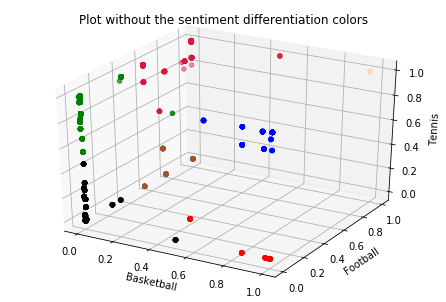

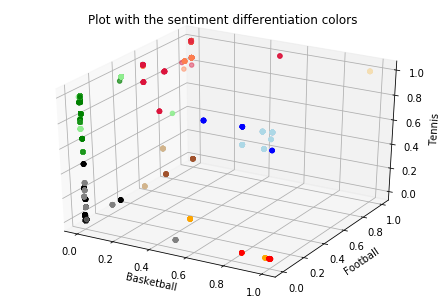

In [9]:
# Get the colors
colors, colors_without_sentiment = colors_assign(features)

# First figure
fig = plt.figure()
ax = Axes3D(fig)
labels = range(len(features['sentiment']))
ax.scatter(features['prob_basketball'], features['prob_football'], features['prob_tennis'], c=colors_without_sentiment)
ax.set_xlabel('Basketball')
ax.set_ylabel('Football')
ax.set_zlabel('Tennis')
ax.set_title('Plot without the sentiment differentiation colors')

# Second figure
fig2 = plt.figure()
ax2 = Axes3D(fig2)
ax2.scatter(features['prob_basketball'], features['prob_football'], features['prob_tennis'], c=colors)
ax2.set_xlabel('Basketball')
ax2.set_ylabel('Football')
ax2.set_zlabel('Tennis')
ax2.set_title('Plot with the sentiment differentiation colors')

# Print a color legend 

### Visualization of the data using Somoclu
Somoclu is a massively parallel implementation of self-organizing maps. It relies on OpenMP for multicore execution
and it can be accelerated by CUDA. The topology of map is either planar or toroid, the grid is rectangular or hexagonal.

We can pass an initial codebook of our choice, but we can also ask Somoclu to initialize the codebook with vectors from the subspace spanned by the first two eigenvalues of the correlation matrix. To do this, we need to pass an optional argument to the constructor.

In this notebook, there are three examples of implementation: one with the default initialization (non PCA) and the continuous sentiment values, another with default initialization (non PCA) and the discretized sentiment values (polarity) and the other one with PCA initialization. 
Principal component analysis (PCA) is a statistical procedure that uses an orthogonal transformation to convert a set of observations of possibly correlated variables (entities each of which takes on various numerical values) into a set of values of linearly uncorrelated variables called principal components.

#### Non PCA initialization and continuous sentiment values

In [10]:
# Define the number of rows and columns for somoclu
n_rows, n_columns = 100, 160
# Initialize the self-organizing map implementation with Somoclu
som = somoclu.Somoclu(n_columns, n_rows, compactsupport=False, maptype="toroid")
# Create an array including the data that the self-organizing map will take into account
new_data = np.array(features[['prob_basketball', 'prob_football', 'prob_tennis','polarity']])
# Traim the self-organizing map with the data
%time som.train(new_data)

CPU times: user 46.9 s, sys: 347 ms, total: 47.2 s
Wall time: 12.6 s


Once that the self-organizing map has learned from the data, we can visualize the component planes that had been generated, one with each feature.

By component plane representation we can visualize the relative component distributions of the input data. Component plane representation can be thought as a sliced version of the self-organizing map. Each component plane has the relative distribution of one data vector component. In this representation, dark values represent relatively small values while lighter values represent relatively large values. By comparing component planes we can see if two components correlate. If the outlook is similar, the components strongly correlate. 

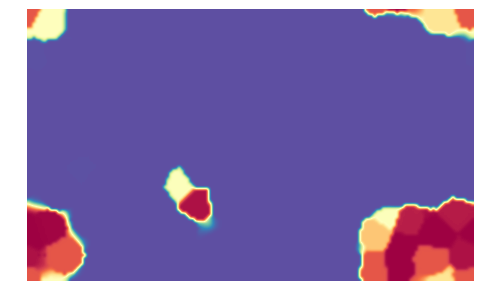

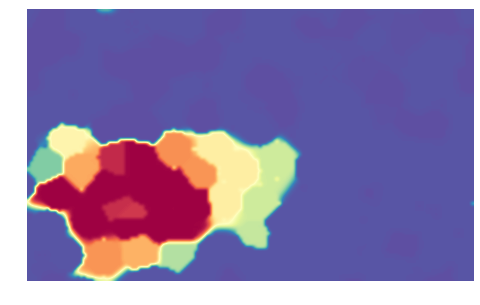

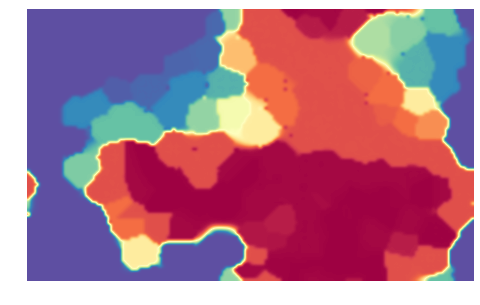

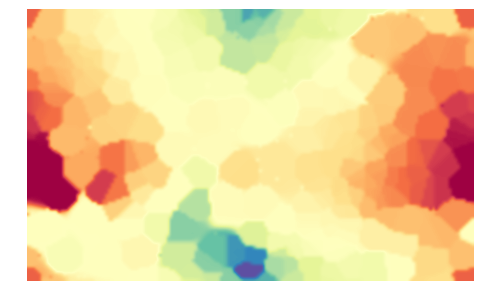

<module 'matplotlib.pyplot' from '/home/julen/.local/lib/python3.5/site-packages/matplotlib/pyplot.py'>

In [11]:
som.view_component_planes()

Now that all of the learning process has been made, the resultant U-matrix can be showed to visualize the result of the self-organizing map. 

The U-matrix (unified distance matrix) is a representation of a self-organizing map (SOM) where the Euclidean distance between the codebook vectors of neighboring neurons is depicted in an image. This image is used to visualize the data in a high-dimensional space using a 2D image.

Since the points are showed on these images, we will use the same colors as previously in order to have a better visualization. Two images are shown, one without sentiment colors and the other with sentiment colors.

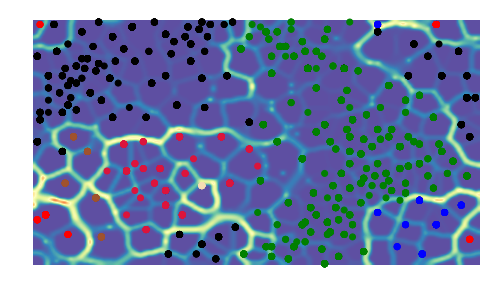

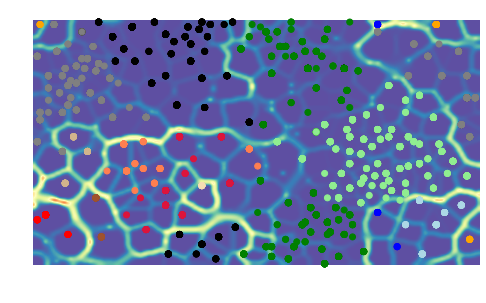

<module 'matplotlib.pyplot' from '/home/julen/.local/lib/python3.5/site-packages/matplotlib/pyplot.py'>

In [12]:
som.view_umatrix(bestmatches=True, bestmatchcolors=colors_without_sentiment)
som.view_umatrix(bestmatches=True, bestmatchcolors=colors)

As a mere fact, here is showed an image with the same U-matrix but with the corresponding labels to each point. The label corresponds to the number of the tweet that is in the tweets array.

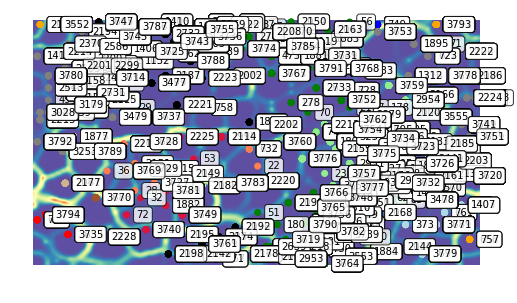

<module 'matplotlib.pyplot' from '/home/julen/.local/lib/python3.5/site-packages/matplotlib/pyplot.py'>

In [13]:
som.view_umatrix(bestmatches=True, labels=labels, bestmatchcolors=colors)

#### Non PCA initialization and discrete sentiment values (polarity)
All of the process here is equal to the one in the previous cells. The only difference is that one of the features is different.

In [14]:
# Initialize the self-organizing map implementation with Somoclu
som_discrete = somoclu.Somoclu(n_columns, n_rows, compactsupport=False, maptype="toroid")
# Create an array including the data that the self-organizing map will take into account
new_data = np.array(features[['prob_basketball', 'prob_football', 'prob_tennis','sentiment']])
# Traim the self-organizing map with the data
%time som_discrete.train(new_data)

CPU times: user 47.3 s, sys: 285 ms, total: 47.6 s
Wall time: 12.5 s


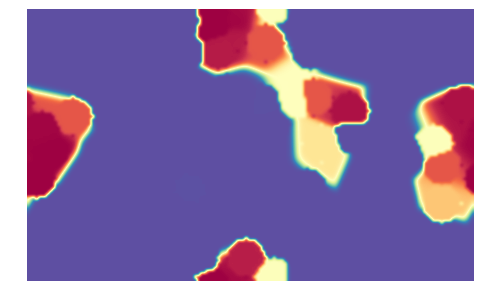

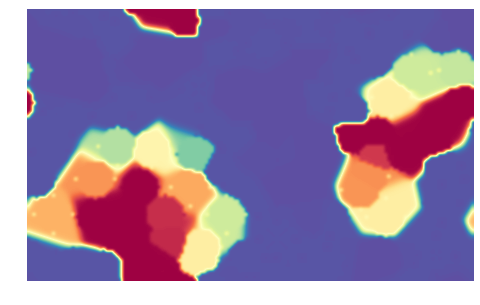

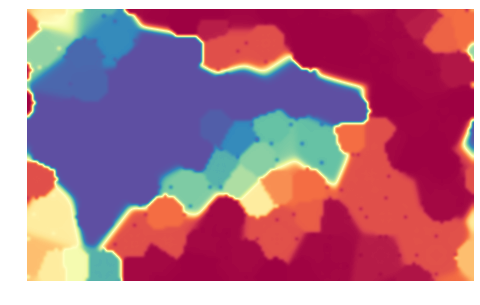

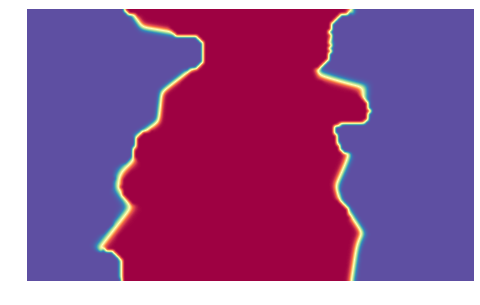

<module 'matplotlib.pyplot' from '/home/julen/.local/lib/python3.5/site-packages/matplotlib/pyplot.py'>

In [15]:
som_discrete.view_component_planes()

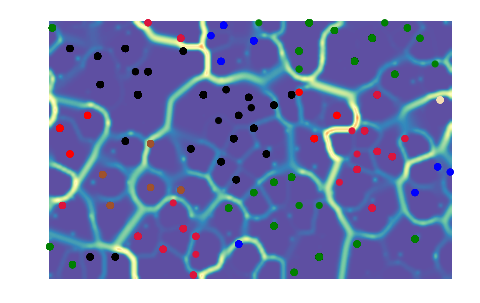

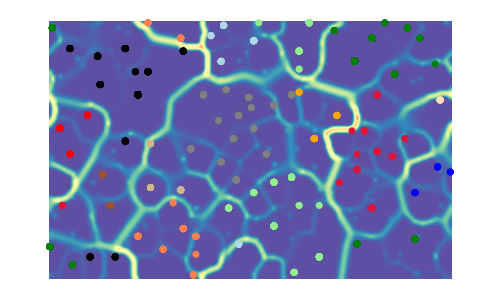

<module 'matplotlib.pyplot' from '/home/julen/.local/lib/python3.5/site-packages/matplotlib/pyplot.py'>

In [16]:
som_discrete.view_umatrix(bestmatches=True, bestmatchcolors=colors_without_sentiment)
som_discrete.view_umatrix(bestmatches=True, bestmatchcolors=colors)

#### PCA Initialization
All of the process here is equal to the one in the previous cells. The only difference is that the initialization is different.

In [17]:
som_pca = somoclu.Somoclu(n_columns, n_rows, compactsupport=False, maptype="toroid", initialization="pca")
new_data = np.array(features[['prob_basketball', 'prob_football', 'prob_tennis','sentiment']])
%time som_pca.train(new_data)

CPU times: user 48.4 s, sys: 880 ms, total: 49.2 s
Wall time: 13.8 s


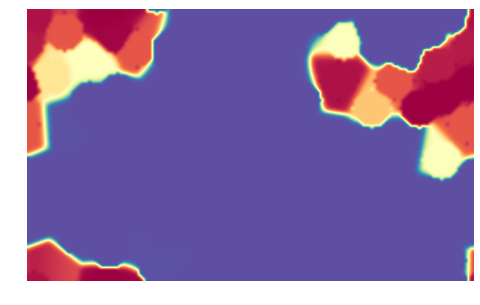

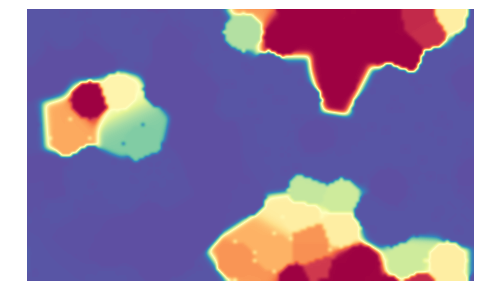

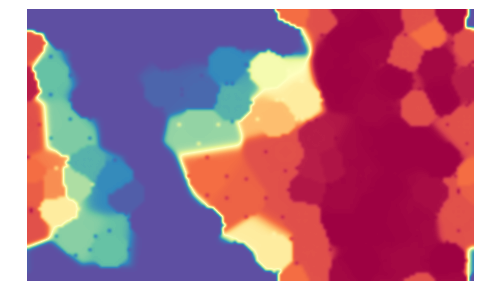

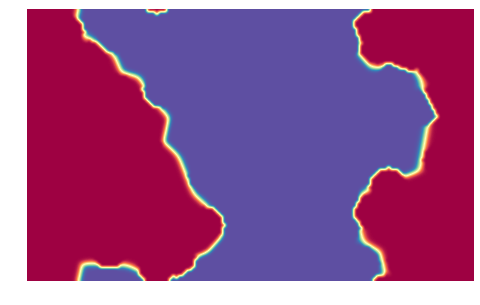

<module 'matplotlib.pyplot' from '/home/julen/.local/lib/python3.5/site-packages/matplotlib/pyplot.py'>

In [18]:
som_pca.view_component_planes()

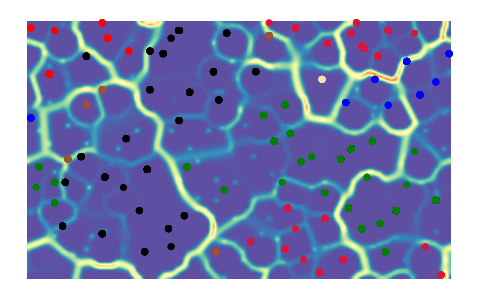

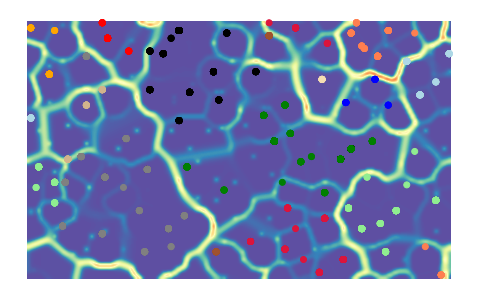

<module 'matplotlib.pyplot' from '/home/julen/.local/lib/python3.5/site-packages/matplotlib/pyplot.py'>

In [19]:
som_pca.view_umatrix(bestmatches=True, bestmatchcolors=colors_without_sentiment)
som_pca.view_umatrix(bestmatches=True, bestmatchcolors=colors)

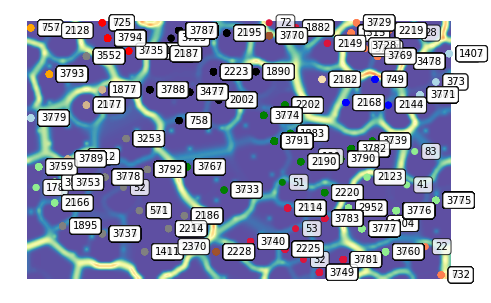

<module 'matplotlib.pyplot' from '/home/julen/.local/lib/python3.5/site-packages/matplotlib/pyplot.py'>

In [20]:
som_pca.view_umatrix(bestmatches=True, labels=labels, bestmatchcolors=colors)

## Analysis of the results

Analysing the three results from the three self-organizing maps, we can see that self-organizing maps take in consideration the correlated features in the creation of the clusters. In this case, the probability features gave a lot of information to the self-organizing map, whereas the sentiment and polarity have been used to create small sub-clusters inside the topic clusters.

Moreover, the structure of the feature is very important in the learning process, therefore, when the feature is continuous, as the polarity, the results look more "random" and the sub-clusters are not perfectly grouped. Nevertheless, when the value is discrete, the component plane shows very concrete differentiation of the data and the U-matrix shows more differentiated sub-clusters.

Also, we can see that the PCA initialization does not add any value to the results of our problem.